In [7]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import cv2
#import plaidml.keras
#plaidml.keras.install_backend()
import tensorflow
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras.backend as K

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
def read_pgm(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [10]:
from sklearn.datasets import load_files

In [11]:
data = load_files('data')
filenames = data['filenames']
labels = data['target']
categories = data['target_names']

In [16]:
batch_size = 10000
X_same = np.zeros([batch_size,2,100,100,1])
y_same = []
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

X_different = np.zeros([batch_size,2,100,100,1])
y_different = []
def get_data(batch_size):
    global X_same, y_same, X_different, y_different
    global face_cascade
    
    count = 0
    for directory in os.listdir('data'):
        for i in range(250):
            pic_1_index = np.random.randint(1,11)
            pic_2_index = np.random.randint(1,11)
            
            pic1 = read_pgm('data/'+str(directory)+'/'+str(pic_1_index)+'.pgm')
            pic2 = read_pgm('data/'+str(directory)+'/'+str(pic_2_index)+'.pgm')
   
            faces1 = face_cascade.detectMultiScale(pic1,1.3,5)
            faces2 = face_cascade.detectMultiScale(pic2,1.3,5)
        
            for x,y,w,h in faces1:
                pic1_use = pic1[y:y+h,x:x+w]
                break
            for x,y,w,h in faces2:
                pic2_use = pic2[y:y+h,x:x+w]
            try:
                pic1_use = cv2.resize(pic1_use,(100,100))
            except:
                print(faces1)
            pic2_use = cv2.resize(pic2_use,(100,100))
            
            pic1_use = np.reshape(pic1_use,(100,100,1))
            pic2_use = np.reshape(pic2_use,(100,100,1))
            X_same[count,0,:,:] = pic1_use
            X_same[count,1,:,:] = pic2_use
            
            y_same.append(1.)
            count+=1
            print(count)
    
  
    
    for i in range(batch_size):
        directories = os.listdir('data')
        dir_1_index = np.random.randint(0,40)
        dir_2_index = np.random.randint(0,40)
        
        if dir_1_index == dir_2_index:
            continue
        else:
            pic_1_index = np.random.randint(1,11)
            pic_2_index = np.random.randint(1,11)
            
            pic1 = read_pgm('data/'+directories[dir_1_index]+'/'+str(pic_1_index)+'.pgm')
            pic2 = read_pgm('data/'+directories[dir_2_index]+'/'+str(pic_2_index)+'.pgm')
            
            faces1 = face_cascade.detectMultiScale(pic1,1.3,5)
            faces2 = face_cascade.detectMultiScale(pic2,1.3,5)
        
            for x,y,w,h in faces1:
                pic1_use = pic1[y:y+h,x:x+w]
                break
            for x,y,w,h in faces2:
                pic2_use = pic2[y:y+h,x:x+w]
            
            pic1_use = cv2.resize(pic1_use,(100,100))
            pic2_use = cv2.resize(pic2_use,(100,100))
            
            pic1_use = np.reshape(pic1_use,(100,100,1))
            pic2_use = np.reshape(pic2_use,(100,100,1))
            
            X_different[i,0,:,:] = pic1_use
            X_different[i,1,:,:] = pic2_use
            y_different.append(0.)
            print(i)

In [17]:
get_data(10000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068


3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714


5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354


6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018


8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665


192
193
194
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
442
443
444
445
446
447
448


2053
2054
2055
2056
2057
2058
2059
2060
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2116
2117
2118
2119
2120
2121
2122
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2155
2156
2157
2158
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2235
2236
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263


3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3956
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976


5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5572
5573
5574
5575
5576
5577
5578
5579
5581
5582
5583
5584
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5609
5610
5611
5612
5613
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687


7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7219
7220
7221
7222
7223
7224
7225
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7303
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373


8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
8984
8985
8986
8987
8988
8989
8990
8991
8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058


In [23]:
X = np.concatenate((X_same,X_different))

y = []
for i in range(10000):
    y.append(1)
for i in range(10000):
    y.append(0)
y = np.array(y)
y = np.reshape(y,(20000,1))

In [24]:
print(X.shape)
print(y.shape)

(20000, 2, 100, 100, 1)
(20000, 1)


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [27]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPool2D,Lambda,Dropout

In [28]:
def euclidean_distance(inputs):
    assert len(inputs) == 2, \
        'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
def contrastive_loss(y_true,y_pred):
    margin=1.
    return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))

In [29]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=(100,100,1)))
    model.add(MaxPool2D())
    model.add(Conv2D(128, (7,7), activation='relu',))
    model.add(Conv2D(128, (4,4), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(256, (4,4), activation='relu'))
    model.add(Conv2D(256, (4,4), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    #model.add(Dense(4096,activation='sigmoid'))
    model.add(Dense(4096,activation='relu'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    # Add a dense layer with a sigmoid unit to generate the similarity score
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [30]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=(100,100,1)))
    model.add(MaxPool2D())
    model.add(Conv2D(128, (7,7), activation='relu',))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(128, (4,4), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(256, (4,4), activation='relu'))
    model.add(Flatten())
    #model.add(Dense(4096,activation='sigmoid'))
    model.add(Dense(4096,activation='relu'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    # Add a dense layer with a sigmoid unit to generate the similarity score
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [38]:
model = get_siamese_model((100,100,1))
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         27413312    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[0][0]    

In [39]:
optimizer = Adam(lr = 0.0001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['acc'])

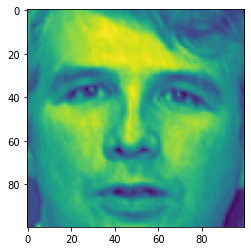

In [40]:
plt.imshow(X_train[-1,1,:,:].reshape(100,100))

In [41]:
y_train = np.array([int(i) for i in y_train])

In [42]:
model.fit([X_train[:,0],X_train[:,1]],y_train,epochs=25,batch_size=5)

Epoch 1/25
2800/2800 [==============================] - 47s 17ms/step - loss: 0.3037 - acc: 0.8985
Epoch 2/25
2800/2800 [==============================] - 45s 16ms/step - loss: 0.1737 - acc: 0.9536
Epoch 3/25
2800/2800 [==============================] - 46s 16ms/step - loss: 0.1483 - acc: 0.9615
Epoch 4/25
2800/2800 [==============================] - 44s 16ms/step - loss: 0.1318 - acc: 0.9671
Epoch 5/25
1163/2800 [===========>..................] - ETA: 27s - loss: 0.1189 - acc: 0.9721

KeyboardInterrupt: 

In [43]:
model.evaluate([X_test[:,0],X_test[:,1]],y_test)

188/188 [==============================] - 5s 26ms/step - loss: 0.1186 - acc: 0.9728


[0.11855606734752655, 0.9728333353996277]

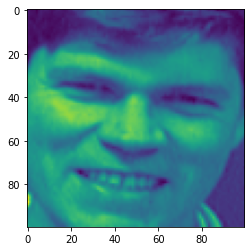

In [63]:
plt.imshow(X_test[5][0][:,:,0])

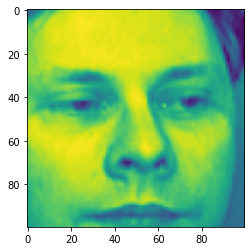

In [64]:
plt.imshow(X_test[5][1][:,:,0])

In [65]:
model.predict([X_test[5][1].reshape((1,100,100,1)),X_test[5][0].reshape((1,100,100,1))])

array([[0.0017074]], dtype=float32)

In [59]:
y_test[0]

array([0])

In [66]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def prep(pic):
    global face_cascade
    gray = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for x,y,w,h in faces:
        jeff = cv2.resize(pic[y:y+h,x:x+w],(100,100))
        jeff = jeff.reshape((1,100,100,3))
        gray_face = cv2.resize(gray[y:y+h,x:x+w],(100,100))
        plt.imshow(gray_face)
        gray_face = gray_face.reshape((1,100,100,1))
        return gray_face,(x,y,w,h)
        #print(gray_face.shape)

In [67]:
pic1 = cv2.imread('rokeya1.png',0)
faces = face_cascade.detectMultiScale(pic1, 1.3, 5)
faces

array([[ 28, 123, 219, 219]], dtype=int32)

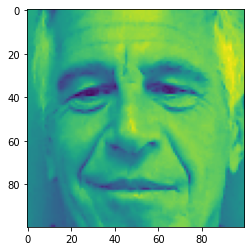

In [71]:
pic1 = cv2.imread('rokeya1.png')
pic2 = cv2.imread('epstein1.png')
mom1,dum = prep(pic1)
me,asd = prep(pic2)

In [73]:
model.predict([mom1,me])

array([[2.4954682e-07]], dtype=float32)